In [1]:
from jax import grad, vmap, numpy as jnp
import matplotlib.pylab as plt

In [72]:
def DoubleSoliton(x, t, c, x0):
    assert c[0] > c[1], 'c0 has to be bigger than c1'
    
    xi0 = jnp.sqrt(c[0]) / 2 * (x - c[0] * t - x0[0]) #  switch to moving coordinate frame
    xi1 = jnp.sqrt(c[1]) / 2 * (x - c[1] * t - x0[1])

    part_1 = 2 * (c[0] - c[1])
    numerator = c[0] * jnp.cosh(xi1)**2 + c[1] * jnp.sinh(xi0)**2
    denominator_1 = (jnp.sqrt(c[0]) - jnp.sqrt(c[1])) * jnp.cosh(xi0 + xi1)
    denominator_2 = (jnp.sqrt(c[0]) + jnp.sqrt(c[1])) * jnp.cosh(xi0 - xi1)
    u = part_1 * numerator / (denominator_1 + denominator_2)**2
    return u

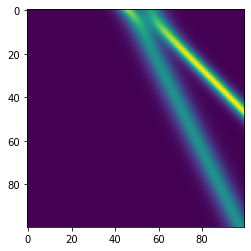

In [141]:
x = jnp.linspace(-20, 20, 100)
t = jnp.linspace(0, 20, 100)
c = [2,1]
x0 = [0,1]

t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
plt.imshow(DoubleSoliton(x_grid, t_grid, c, x0))

In [142]:
u_jax = DoubleSoliton(x_grid, t_grid, c, x0)

In [143]:
u_x = vmap(grad(lambda x, t: DoubleSoliton(x, t, c, x0), argnums=0))(x_grid.ravel(), t_grid.ravel()).reshape(100,100)
u_xx = vmap(grad(grad(lambda x, t: DoubleSoliton(x, t, c, x0), argnums=0), argnums=0))(x_grid.ravel(), t_grid.ravel()).reshape(100,100)

In [144]:
jnp.any(jnp.isnan(u_xx))

DeviceArray(True, dtype=bool)

Text(0, 0.5, 't')

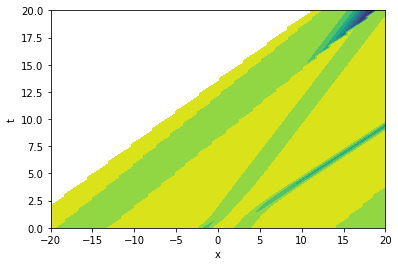

In [145]:
plt.contourf(x_grid, t_grid, u_xx)
plt.xlabel('x')
plt.ylabel('t')

In [146]:
from deepymod.data import kdv
import torch
import numpy as np

In [147]:
x_t = torch.tensor(np.array(x_grid), requires_grad=True)
t_t = torch.tensor(np.array(t_grid), requires_grad=True)

In [148]:
u_t = kdv.DoubleSoliton(x_t, t_t, c, x0)

In [149]:
jnp.max(jnp.abs(u_jax - u_t.detach().numpy()))

DeviceArray(1.1622906e-06, dtype=float32)

In [150]:
torch.autograd.grad(u_t, x_t, torch.ones_like(u_t), create_graph=True)

(tensor([[ 8.8560e-09,  1.3270e-08,  1.9885e-08,  ..., -1.4659e-07,
          -9.7857e-08, -6.5328e-08],
         [ 7.2317e-09,  1.0835e-08,  1.6234e-08,  ..., -1.7943e-07,
          -1.1978e-07, -7.9963e-08],
         [ 5.9065e-09,  8.8486e-09,  1.3257e-08,  ..., -2.1965e-07,
          -1.4663e-07, -9.7881e-08],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.5933e-02,
          -1.5786e-01, -1.9016e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.8852e-02,
          -1.2642e-01, -1.7907e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.1326e-02,
          -8.5933e-02, -1.5786e-01]], grad_fn=<AddBackward0>),)

In [151]:
u_t_xx = torch.autograd.grad(torch.autograd.grad(u_t, x_t, torch.ones_like(x_t), create_graph=True)[0], x_t, torch.ones_like(u_t), retain_graph=True)[0]

Text(0, 0.5, 't')

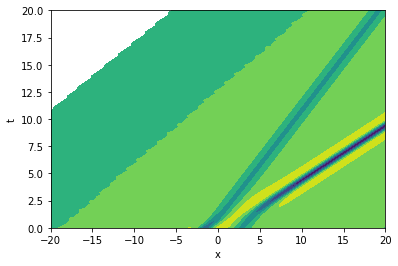

In [152]:
plt.contourf(x_grid, t_grid, u_t_xx.detach())
plt.xlabel('x')
plt.ylabel('t')

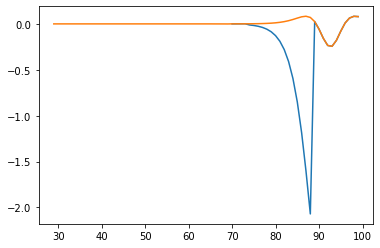

In [153]:
plt.plot(u_xx[90, :])
plt.plot(u_t_xx.detach()[90, :])

In [154]:
u_t_xx.shape

torch.Size([100, 100])

In [155]:
u_xx.shape

(100, 100)

In [156]:
from deepymod.data.base import Dataset

In [157]:
data = Dataset(kdv.DoubleSoliton, c=c, x0=x0)

In [158]:
theta = data.library(x_t.reshape(-1, 1), t_t.reshape(-1, 1))

In [159]:
jnp.any(jnp.isnan(theta))

DeviceArray(True, dtype=bool)

In [160]:
u_xx_theta = theta[:, 2].reshape(x_t.shape)

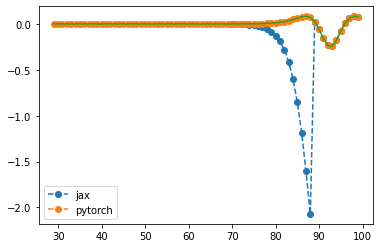

In [169]:
plt.plot(u_xx[90, :], 'o--',label='jax')
plt.plot(u_t_xx.detach()[90, :], 'o--', label='pytorch')
plt.plot(u_xx_theta[90, :])

plt.legend()